In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Projeto Olist: Fase 2 - Análise de Negócio

## 1. Carregamento dos Dados Processados

**Processo:** O ponto de partida para a análise de negócio são os dados previamente limpos e estruturados pelo notebook de ETL. Nesta etapa, carregamos os arquivos `df_analise_olist.csv` e `df_pagamentos_agregado_olist.csv`. Um passo crucial é a reconversão das colunas de data para o tipo `datetime`, garantindo a correta manipulação de informações temporais.


In [60]:
# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Caminho para os arquivos CSV gerados pelo notebook de ETL
caminho_analise = '../data/processed/df_analise_olist.csv'
caminho_pagamentos = '../data/processed/df_pagamentos_agregado_olist.csv'

# Carregando os dados processados

df_pagamentos_agregado = pd.read_csv(caminho_pagamentos)
df_analise = pd.read_csv(caminho_analise)

# Convertendo colunas de data para o tipo datetime
colunas_data = ['order_purchase_timestamp', 'order_approved_at',
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date', 'shipping_limit_date',
                'review_creation_date', 'review_answer_timestamp']

for col in colunas_data:
    df_analise[col] = pd.to_datetime(df_analise[col], errors='coerce')
    

print("Dados carregados e colunas de data convertidas com sucesso.")
df_analise.info()
                        

Dados carregados e colunas de data convertidas com sucesso.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119118 entries, 0 to 119117
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119118 non-null  object        
 1   customer_id                    119118 non-null  object        
 2   order_status                   119118 non-null  object        
 3   order_purchase_timestamp       119118 non-null  datetime64[ns]
 4   order_approved_at              118956 non-null  datetime64[ns]
 5   order_delivered_carrier_date   117034 non-null  datetime64[ns]
 6   order_delivered_customer_date  115706 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119118 non-null  datetime64[ns]
 8   order_item_id                  118286 non-null  float64       
 9   product_id                     118286 non-null  object        
 10  seller_i

# Perguntas de Negócio

### Análise Geral de Vendas

**Processo:** O foco aqui é criar algumas visões de negócio. As visões escolhidas foram as de receita total, Quantidade de Pedidos por mês e o TOP 10 categorias vendidas. 
Para isso foram criadas 3 variaveis: `receita_total`, `sazonalidade_vendas` e `categorias_mais_vendidas`.

In [61]:
# Qual a receita total? Usar a df_pagamentos_agregado para isso, para evitar duplicidade de valores.
receita_total = df_pagamentos_agregado['valor_total_pagamento'].sum()
print(f"A Receita total foi de: R$ {receita_total:,.2f}")

# Qual a sazonalidade das vendas ao longo do ano?
sazonalidade_vendas = df_analise.groupby('mes_compra')['order_id'].nunique().sort_index()
print("Quantidade de Pedidos por Mês:")
print(sazonalidade_vendas)

# Quais categorias de produtos mais vendidas?
categorias_mais_vendidas = df_analise['product_category_name'].value_counts().head(10)
print("Top 10 Categorias de Produtos mais Vendidas:")
print(categorias_mais_vendidas)

A Receita total foi de: R$ 20,575,931.74
Quantidade de Pedidos por Mês:
mes_compra
1      8067
2      8496
3      9893
4      9343
5     10572
6      9409
7     10315
8     10843
9      4304
10     4958
11     7543
12     5674
Name: order_id, dtype: int64
Top 10 Categorias de Produtos mais Vendidas:
product_category_name
cama_mesa_banho           11987
beleza_saude              10032
esporte_lazer              9001
moveis_decoracao           8828
informatica_acessorios     8149
utilidades_domesticas      7380
relogios_presentes         6211
telefonia                  4724
ferramentas_jardim         4589
automotivo                 4399
Name: count, dtype: int64


## Análise de Clientes (RFM)

### 2.1 Cálculo dos Atributos RFM

**Objetivo:** Calcular os três pilares da análise RFM para cada cliente único:
- **Recência (R):** Há quantos dias foi a última compra?
- **Frequência (F):** Quantas compras distintas o cliente já fez?
- **Valor Monetário (M):** Qual o valor total gasto pelo cliente?

**Processo:** Utilizaremos o `df_analise` para agrupar os dados por `customer_unique_id`. Para a recência, calcularemos a diferença entre a data da última compra de cada cliente e uma data de referência ("snapshot"). A frequência será a contagem de pedidos únicos e o valor monetário será a soma dos preços dos itens.

In [62]:
# Definir a data de referência como o dia após a última compra no dataset
snapshot_data = df_analise['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Calcular RFM (Recência, Frequência, Valor Monetário)
# Agrupar por cliente unico e calcular as métricas RFM
df_rfm = df_analise.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda date: (snapshot_data - date.max()).days, # Recência
    'order_id':'nunique', # Frequência
    'price': "sum" # Valor Monetário
}).reset_index()

# Renomear as colunas 
df_rfm.rename(columns = {
    'order_purchase_timestamp': 'recencia',
    'order_id': 'frequencia',
    'price': 'valor_monetario'}, inplace=True)  

print("Visão Geral do RFM:")
print(df_rfm.head())


Visão Geral do RFM:
                 customer_unique_id  recencia  frequencia  valor_monetario
0  0000366f3b9a7992bf8c76cfdf3221e2       161           1           129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f       164           1            18.90
2  0000f46a3911fa3c0805444483337064       586           1            69.00
3  0000f6ccb0745a6a4b88665a16c9f078       370           1            25.99
4  0004aac84e0df4da2b147fca70cf8255       337           1           180.00


### 2.2. Scoring e Segmentação de Clientes

**Decisão Estratégica:** Os scores numéricos de RFM são a base técnica, mas para gerar valor de negócio, precisamos traduzi-los em segmentos com nomes claros e acionáveis. Criaremos uma segmentação baseada nos scores de Recência e Frequência para identificar nossos grupos de clientes mais importantes.

In [63]:
# Criar os scores de RFM
df_rfm['R_Score'] = pd.qcut(df_rfm['recencia'], 5, labels=[5, 4, 3, 2, 1]) #Maior recência (menos dias), maior score
df_rfm['F_Score'] = pd.qcut(df_rfm['frequencia'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]) #Maior frequência, maior score
df_rfm['M_Score'] = pd.qcut(df_rfm['valor_monetario'], 5, labels=[1, 2, 3, 4, 5]) #Maior valor monetário, maior score

# Criar função para aplicar segmentação
def segmentacao_cliente(row):
    # Combina os scores R e F para formar o RFM_SCORE
    if row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Campeões'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Clientes Leais'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'Potenciais Leais'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'Em Risco'
    else:
        return 'Perdidos'
    
# Criando coluna de segmentação
df_rfm['Segmento'] = df_rfm.apply(segmentacao_cliente, axis=1)
print("Tabela RFM criada com sucesso")
print(df_rfm.head())
    


Tabela RFM criada com sucesso
                 customer_unique_id  recencia  frequencia  valor_monetario  \
0  0000366f3b9a7992bf8c76cfdf3221e2       161           1           129.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f       164           1            18.90   
2  0000f46a3911fa3c0805444483337064       586           1            69.00   
3  0000f6ccb0745a6a4b88665a16c9f078       370           1            25.99   
4  0004aac84e0df4da2b147fca70cf8255       337           1           180.00   

  R_Score F_Score M_Score          Segmento  
0       4       1       4  Potenciais Leais  
1       4       1       1  Potenciais Leais  
2       1       1       2          Perdidos  
3       2       1       1          Perdidos  
4       2       1       4          Perdidos  


### 2.3. Análise Visual dos Segmentos

**Objetivo:** Quantificar e visualizar a distribuição dos clientes em cada segmento. Isso nos dará uma visão clara da saúde da nossa base de clientes: temos mais campeões ou mais clientes em risco?


C:\Users\Matheus\AppData\Local\Temp\ipykernel_7636\2080921891.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=segmento_count.index, y=segmento_count.values, palette='viridis', order=segmento_count.index)


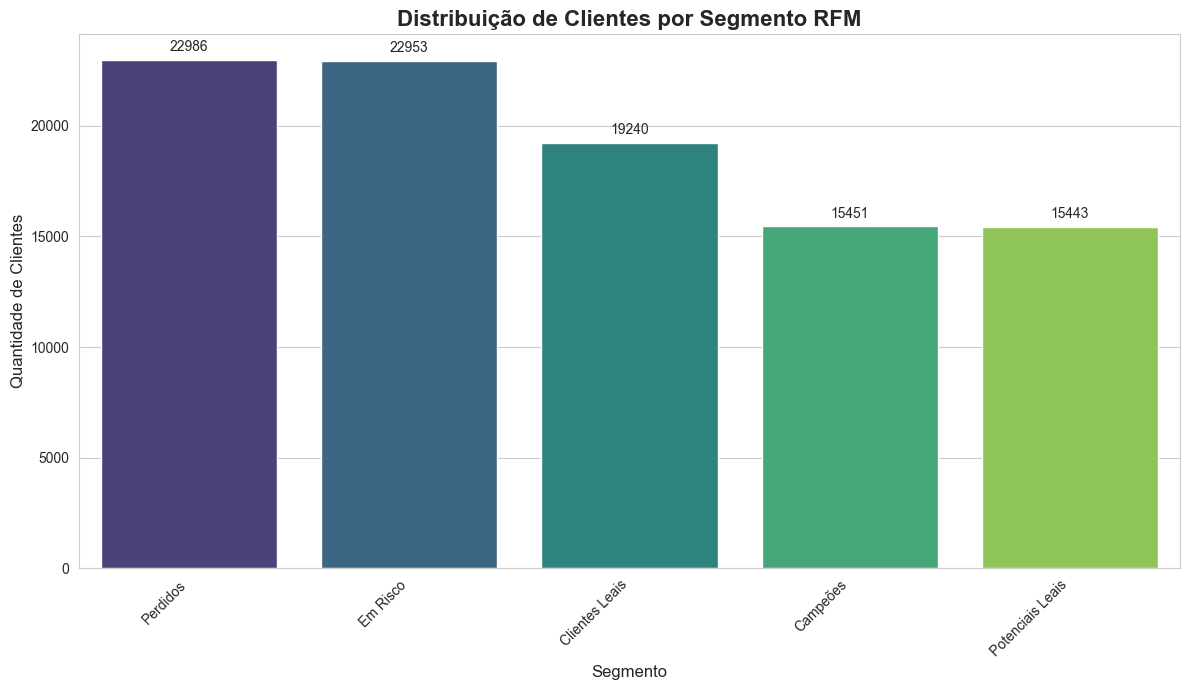

In [64]:
# Calcular a quantidade de clientes em cada segmento
segmento_count = df_rfm['Segmento'].value_counts().sort_values(ascending=False)

# Cria um grafico de barras para visualizar a distribuição dos segmentos
plt.figure(figsize=(12,7))
ax = sns.barplot(x=segmento_count.index, y=segmento_count.values, palette='viridis', order=segmento_count.index)

# Adiciona títulos e rótulos
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9),
                textcoords='offset points')
    
    
plt.title('Distribuição de Clientes por Segmento RFM', fontsize=16, weight='bold')
plt.xlabel('Segmento', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.xticks(rotation=45, ha ='right')
plt.tight_layout()
plt.show()



## 3. Análise Geográfica e Logística

### 3.1 Análise de Vendas por Estado

**Objetivo:** Identificar os principais mercados da Olist no Brasil, visualizando os estados com maior volume de pedidos. Isso ajuda a direcionar estratégias de marketing e logística regionais.


C:\Users\Matheus\AppData\Local\Temp\ipykernel_7636\695618944.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=vendas_por_estados.index, y=vendas_por_estados.values, palette='coolwarm', order=vendas_por_estados.index)


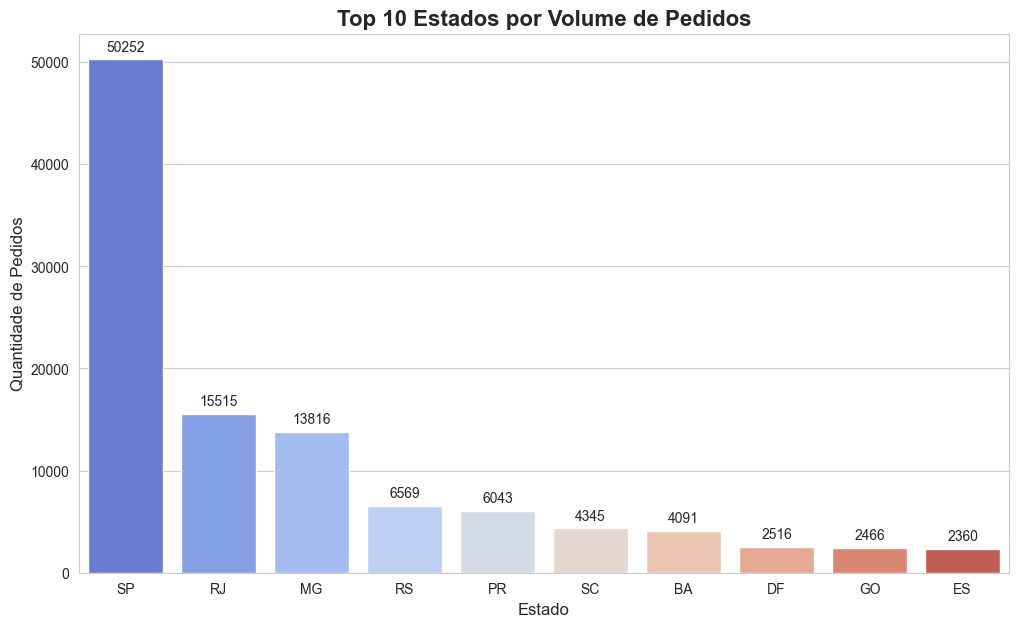

In [65]:
# Contar as vendas por estado
vendas_por_estados = df_analise['customer_state'].value_counts().head(10)

# Cria um grafico de barras para o top 10 estados com mais vendas
plt.figure(figsize=(12,7))
ax = sns.barplot(x=vendas_por_estados.index, y=vendas_por_estados.values, palette='coolwarm', order=vendas_por_estados.index)

# Adiciona títulos e rótulos
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9),
                textcoords='offset points')
    
plt.title('Top 10 Estados por Volume de Pedidos', fontsize=16, weight='bold')
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Quantidade de Pedidos', fontsize=12)
plt.show()


### 3.2 Análise do Tempo de Entrega

**Objetivo:** Avaliar a eficiência logística da Olist, calculando o tempo médio de entrega para os principais estados. Isso pode revelar gargalos logísticos e oportunidades de melhoria.


C:\Users\Matheus\AppData\Local\Temp\ipykernel_7636\1413294599.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tempo_media_entrega.index, y=tempo_media_entrega.values, palette='YlGnBu_r', order=tempo_media_entrega.index)


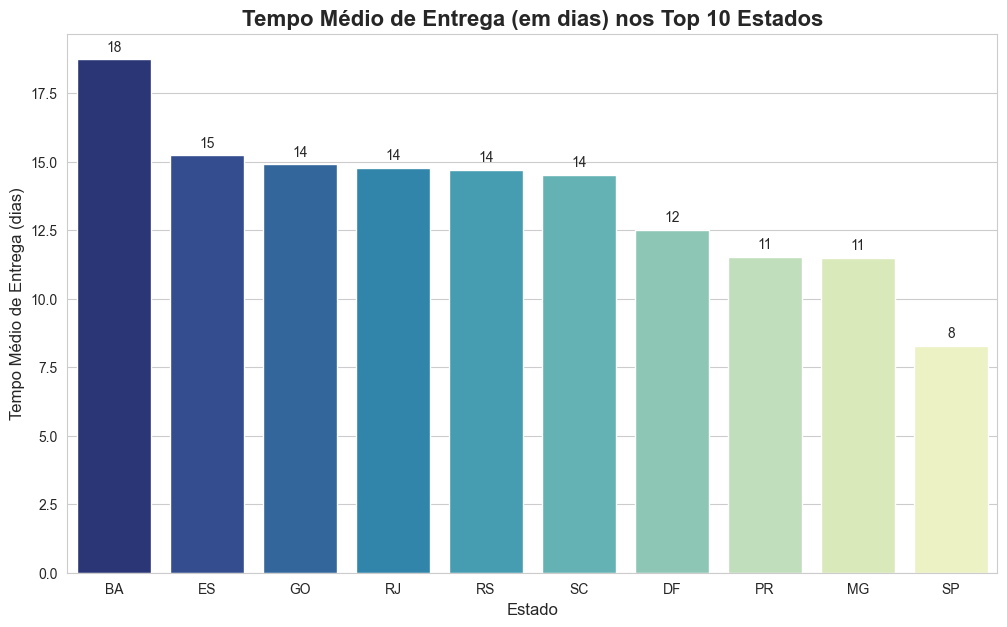

In [66]:
# Separar top 10 estados
top_10_estados = vendas_por_estados.index

# Filtrar o DataFrame para incluir apenas os pedidos dos top 10 estados
df_top_estados = df_analise[df_analise['customer_state'].isin(top_10_estados)]

# Calcula o tempo medio de entrega por estado, agrupando por estado e ordenando
tempo_media_entrega = df_top_estados.groupby('customer_state')['tempo_entrega'].mean().sort_values(ascending=False)

# Cria um grafico de barras para o tempo médio de entrega por estado
plt.figure(figsize=(12,7))
ax = sns.barplot(x=tempo_media_entrega.index, y=tempo_media_entrega.values, palette='YlGnBu_r', order=tempo_media_entrega.index)

# Adiciona títulos e rótulos
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9),
                textcoords='offset points')
    
plt.title('Tempo Médio de Entrega (em dias) nos Top 10 Estados', fontsize=16, weight='bold')
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Tempo Médio de Entrega (dias)', fontsize=12)
plt.show()

### 3.3 Correlação entre Atraso na Entrega e Satisfação do Cliente

**Hipótese de Negócio:** A experiência de entrega (especialmente os atrasos) é um fator crítico para a satisfação e retenção de clientes. Clientes com entregas atrasadas tendem a dar notas de avaliação mais baixas, o que pode explicar a alta quantidade de clientes nos segmentos "Em Risco" e "Perdidos".

**Objetivo:** Validar esta hipótese, analisando a relação direta entre o status da entrega (adiantada, no prazo, atrasada) e a nota de avaliação (`review_score`) deixada pelo cliente.


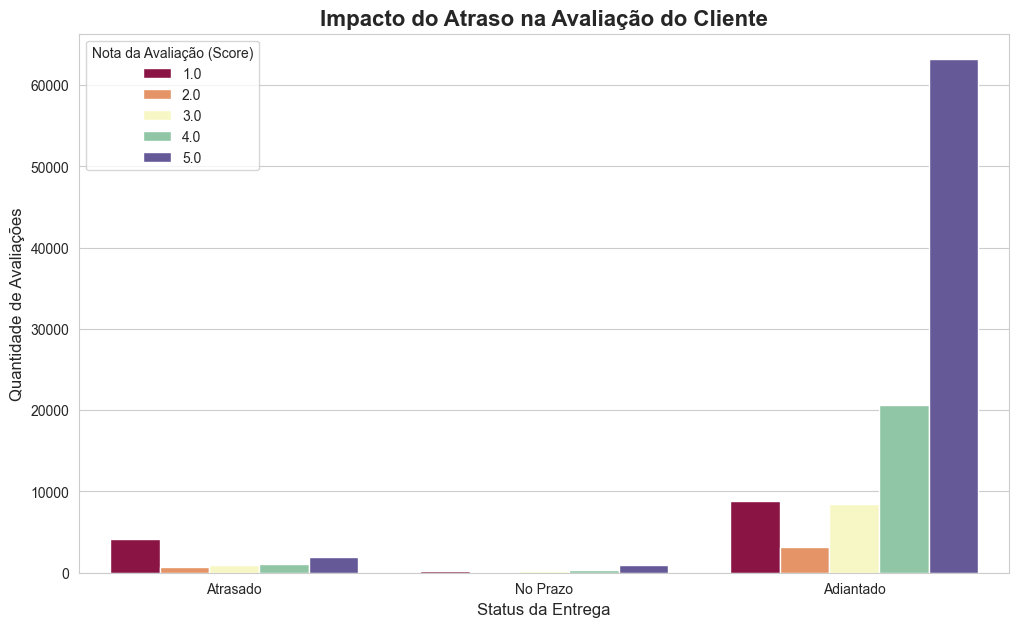

In [67]:
# Criar coluna categorica para o status de entrega
def status_entrega(dias):
    if dias < 0:
        return 'Atrasado'
    elif dias == 0:
        return 'No Prazo'
    else :
        return 'Adiantado'
    
# Usamos .copy() para evitar SettingWithCopyWarning e removemos nulos para a análise
df_analise_logistica = df_analise.dropna(subset=['diferenca_entrega_estimada', 'review_score']).copy()
df_analise_logistica['Status_Entrega'] = df_analise_logistica['diferenca_entrega_estimada'].apply(status_entrega)

# Criar a visualização
plt.figure(figsize=(12, 7))
sns.countplot(data=df_analise_logistica, x='Status_Entrega', hue='review_score', palette='Spectral', order=['Atrasado', 'No Prazo', 'Adiantado'])

plt.title('Impacto do Atraso na Avaliação do Cliente', fontsize=16, weight='bold')
plt.xlabel('Status da Entrega', fontsize=12)
plt.ylabel('Quantidade de Avaliações', fontsize=12)
plt.legend(title='Nota da Avaliação (Score)')
plt.show()

## 4. Preparação dos Dados para Modelo Star Schema

### 4.1 Criação da Tabela Fato (fato_vendas)

**Objetivo:** Criar a tabela fato central, contendo as chaves para as dimensões e as métricas numéricas de cada transação (item de pedido). As colunas serão renomeadas para seguir as melhores práticas de semântica em BI (ex: `price` -> `valor_item`).


In [68]:
# Selecionar colunas para a tabela Fato e renomeá-las
colunas_fato = {
    'order_id': 'id_pedido',
    'order_item_id': 'id_item_pedido',
    'product_id': 'id_produto',
    'seller_id': 'id_vendedor',
    'customer_unique_id': 'id_cliente_unico',
    'order_purchase_timestamp': 'data_pedido',
    'price': 'valor_item',
    'freight_value': 'valor_frete',
    'review_score': 'nota_avaliacao'
}

f_vendas = df_analise[colunas_fato.keys()].copy()
f_vendas.rename(columns=colunas_fato, inplace=True)
f_vendas['data_pedido'] = f_vendas['data_pedido'].dt.date


print("Tabela Fato de Vendas criada com sucesso")
print(f_vendas.info())

Tabela Fato de Vendas criada com sucesso
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119118 entries, 0 to 119117
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id_pedido         119118 non-null  object 
 1   id_item_pedido    118286 non-null  float64
 2   id_produto        118286 non-null  object 
 3   id_vendedor       118286 non-null  object 
 4   id_cliente_unico  119118 non-null  object 
 5   data_pedido       119118 non-null  object 
 6   valor_item        118286 non-null  float64
 7   valor_frete       118286 non-null  float64
 8   nota_avaliacao    118121 non-null  float64
dtypes: float64(4), object(5)
memory usage: 8.2+ MB
None


### 4.2 Criação da Dimensão Cliente (dim_clientes)

**Objetivo:** Criar uma tabela dimensão com informações únicas de cada cliente, incluindo a segmentação RFM que calculamos.


In [69]:
# Unir df_analise com df_rfm para adicionar informações de segmento
dim_clientes_temp = pd.merge(df_analise[['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']],
                             df_rfm[['customer_unique_id', 'Segmento']],
                             on='customer_unique_id',
                             how='left')

# Remover duplicatas para garantir uma linha por cliente
dim_clientes = dim_clientes_temp.drop_duplicates(subset=['customer_unique_id']).copy()

# Renomear colunas
dim_clientes.rename(columns={
    'customer_unique_id': 'id_cliente_unico',
    'customer_zip_code_prefix': 'cep_cliente',
    'customer_city': 'cidade_cliente',
    'customer_state': 'estado_cliente',
    'Segmento': 'segmento_cliente'
}, inplace=True)


print("\nTabela dim_clientes criada:")
dim_clientes.info()


Tabela dim_clientes criada:
<class 'pandas.core.frame.DataFrame'>
Index: 96073 entries, 0 to 119117
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_cliente_unico  96073 non-null  object
 1   cep_cliente       96073 non-null  int64 
 2   cidade_cliente    96073 non-null  object
 3   estado_cliente    96073 non-null  object
 4   segmento_cliente  96073 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.4+ MB


### 4.3 Criação da Dimensão Produto (dim_produtos)

**Objetivo:** Criar uma tabela dimensão com os atributos de cada produto. Incluiremos dados físicos (como peso) para possibilitar análises mais profundas sobre a logística.


In [70]:
# Selecionar e remover duplicatas de produtos
colunas_produto = [
    'product_id',
    'product_category_name',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]
dim_produtos = df_analise[colunas_produto].drop_duplicates(subset=['product_id']).copy()

# Renomear colunas
dim_produtos.rename(columns={
    'product_id': 'id_produto',
    'product_category_name': 'categoria_produto',
    'product_weight_g': 'peso_g_produto',
    'product_length_cm': 'comprimento_cm_produto',
    'product_height_cm': 'altura_cm_produto',
    'product_width_cm': 'largura_cm_produto'
}, inplace=True)


print("\nTabela dim_produtos criada:")
dim_produtos.info()


Tabela dim_produtos criada:
<class 'pandas.core.frame.DataFrame'>
Index: 32946 entries, 0 to 119117
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_produto              32945 non-null  object 
 1   categoria_produto       32945 non-null  object 
 2   peso_g_produto          32945 non-null  float64
 3   comprimento_cm_produto  32945 non-null  float64
 4   altura_cm_produto       32945 non-null  float64
 5   largura_cm_produto      32945 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.8+ MB


### 4.4 Exportação dos Arquivos para o Power BI

**Objetivo:** Salvar as tabelas Fato e Dimensão como arquivos CSV separados, prontos para serem importados no Power BI.


In [71]:
# Definir pasta de saída
output_dir_model = '../data/model/'
if not os.path.exists(output_dir_model):
    os.makedirs(output_dir_model)

# Exportar cada tabela
f_vendas.to_csv(os.path.join(output_dir_model, 'f_vendas.csv'), index=False)
dim_clientes.to_csv(os.path.join(output_dir_model, 'dim_clientes.csv'), index=False)
dim_produtos.to_csv(os.path.join(output_dir_model, 'dim_produtos.csv'), index=False)

print(f"Arquivos do modelo Star Schema salvos com sucesso na pasta: {output_dir_model}")


Arquivos do modelo Star Schema salvos com sucesso na pasta: ../data/model/
